In [1]:
import os, sys, warnings
from io import BytesIO

sys.path.insert(0, os.path.abspath('') + '/ISIC_Model')
warnings.filterwarnings('ignore')

#Own pretrained model to handle the tabular metadata and images
from ISIC_Model.arch import EfficientUNetWithTabular

import torch, pandas, numpy, lightgbm, h5py
from PIL import Image
from tqdm import tqdm
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import RobustScaler, StandardScaler
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from typing import Any, Callable, Dict, Tuple, Union

class Util:
    metadata_fp: str= os.path.abspath('')+\
                    "/data/train-metadata.csv"
    metadata_test_fp: str= os.path.abspath('')+\
                    "/data/test-metadata.csv"
    metadata_submission_fp:str= os.path.abspath('')+\
                    "/data/sample_submission.csv"
    test_image_dir:str= os.path.abspath('')+\
                    "/data/test-image.hdf5"
    train_image_dir:str= os.path.abspath('')+\
                    "/data/train-image/image"
    coefficient_of_variation: Callable[[pandas.Series], float] = \
                            lambda data: abs(data.std()/ data.mean())
    neigh= NearestNeighbors(n_neighbors=1)
    lightgbm_kwargs: Dict[str, Union[str, float, int]]={
        'objective': 'binary',
        'n_estimators': 512,
        'learning_rate': 5e-3,
        'num_leaves': 57,
        'bagging_freq': 256,
        'pos_bagging_fraction': 0.777,
        'neg_bagging_fraction': 0.077,
        'feature_fraction': 0.78,
        'random_seed': 42,
        "verbosity": -1,
        'max_depth': -1,
        'lambda_l1': 0.1,
        'lambda_l2': 0.1,
        'boosting': 'gbdt',
        'metric': 'binary_logloss'
    }
    transform= transforms.Compose([
                transforms.Resize(480),
                transforms.CenterCrop(448),
                transforms.ToTensor(),
                transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])]
    )
    bin_feats:list[str]= ['sex', 'anterior torso', 'head/neck', 'lower extremity', 'posterior torso', 'upper extremity']
    model_fp:str= '/home/abiel/workspace/kaggle/ISIC_Model/logs/checkpoints/EfficientUNetWithTabular_ck7/EfficientUNetWithTabular_epoch_39.pt'
    dataloader_kwargs:Dict[str, Union[int, bool]]= {'batch_size': 32, 'shuffle': False, 'num_workers': 12, 'pin_memory': True}

In [2]:
metadata= pandas.read_csv(Util.metadata_fp)
metadata.drop(
    columns= ['lesion_id', 'image_type' ,'tbp_tile_type', 'tbp_lv_location', 'tbp_lv_dnn_lesion_confidence', ## Create a DNN that replaces the confidence | then that might be a good model
                'tbp_lv_location_simple', 'tbp_lv_x', 'tbp_lv_y', 'tbp_lv_z', 'copyright_license', 'iddx_full',  
                'iddx_1', 'iddx_2', 'iddx_3', 'iddx_4', 'iddx_5', 'mel_mitotic_index', 'mel_thick_mm', 'attribution'],
    inplace= True)

metadata_test= pandas.read_csv(Util.metadata_test_fp)
metadata_test[[['anterior torso', 'head/neck', 'upper extremity']]]= 0
metadata_test.drop(
    columns= ['image_type' ,'tbp_tile_type', 'tbp_lv_location','tbp_lv_location_simple', 
              'tbp_lv_x', 'tbp_lv_y', 'tbp_lv_z', 'copyright_license', 'attribution'],
    inplace= True)

In [3]:
metadata['target'].value_counts()

target
0    400666
1       393
Name: count, dtype: int64

<Axes: >

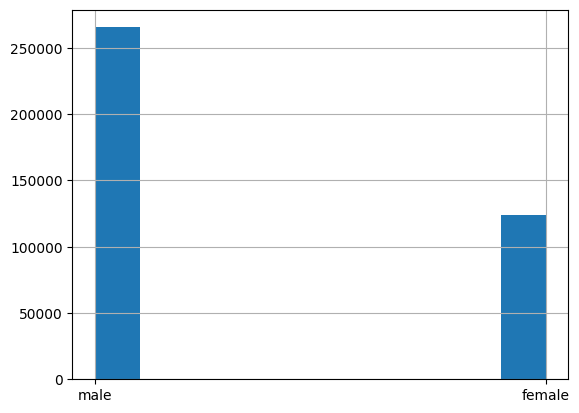

In [4]:
metadata['sex'].hist()

<Axes: >

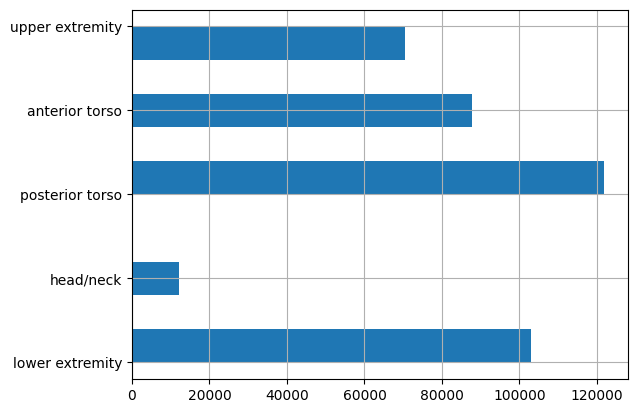

In [5]:
metadata['anatom_site_general'].hist(orientation= 'horizontal')

In [6]:
def NNImputer(df: pandas.DataFrame, columns: list[str]):
    X= df.drop(columns=columns)
    y= df[columns]

    non_nan_mask= y.notna().all(axis=1)
    X_clean= X[non_nan_mask]
    y_clean= y[non_nan_mask]

    Util.neigh.fit(X_clean)

    imputed_df= df.copy()
    for col in columns:
        nan_mask= imputed_df[col].isna()
        X_nan= X[nan_mask]

        if not X_nan.empty:
            _, indices= Util.neigh.kneighbors(X_nan)
            
            imputed_values= y_clean[col].iloc[indices.flatten()].values
            imputed_df.loc[nan_mask, col]= imputed_values
            
    return imputed_df[columns]

columns_to_impute= metadata.columns[metadata.isna().any()].tolist()
metadata[columns_to_impute]= NNImputer(metadata.drop(columns=['patient_id', 'isic_id']), columns=columns_to_impute)
del columns_to_impute

In [7]:
metadata['sex']= [int(sex== 'male') for sex in metadata['sex']]
metadata_test['sex']= [int(sex!= 'female') for sex in metadata_test['sex']]
metadata= metadata.join(pandas.get_dummies(metadata['anatom_site_general']).astype(int))
metadata.drop(columns=['anatom_site_general'], inplace=True)

metadata_test= metadata_test.join(pandas.get_dummies(metadata_test['anatom_site_general']).astype(int))
metadata_test.drop(columns=['anatom_site_general'], inplace=True)

In [8]:
cv_series= Util.coefficient_of_variation(metadata.drop(
    columns=['isic_id', 'patient_id', 'target', 'sex', 'anterior torso', 'head/neck', 'lower extremity', 'posterior torso', 'upper extremity']))

robust_cols= cv_series[cv_series >= 1].index.tolist() #high variability
standard_cols= cv_series[cv_series < 1].index.tolist()
df= metadata.copy()

df[robust_cols]= StandardScaler().fit_transform(metadata[robust_cols])
df[standard_cols]= RobustScaler().fit_transform(metadata[standard_cols])

del robust_cols, standard_cols, cv_series

In [9]:
#data used to pretrain "EfficientUNet with Tabular" Model
df

,isic_id,target,patient_id,age_approx,sex,clin_size_long_diam_mm,tbp_lv_A,tbp_lv_Aext,tbp_lv_B,tbp_lv_Bext,...,tbp_lv_radial_color_std_max,tbp_lv_stdL,tbp_lv_stdLExt,tbp_lv_symm_2axis,tbp_lv_symm_2axis_angle,anterior torso,head/neck,lower extremity,posterior torso,upper extremity
0,ISIC_0015670,0,IP_1235828,0.00,1,-0.214286,0.088969,0.331669,-0.180169,-0.471027,...,-1.170833,-0.074578,0.700479,1.806510,-0.055556,0,0,1,0,0
1,ISIC_0015845,0,IP_8170065,0.00,1,-1.474026,2.394676,2.281941,-0.265477,-0.369083,...,-1.170833,-0.660788,2.530633,0.020034,-0.388889,0,1,0,0,0
2,ISIC_0015864,0,IP_6724798,0.00,1,0.019481,0.557706,0.517252,1.413358,1.163229,...,-1.170833,-0.219546,-0.285606,0.466653,0.166667,0,0,0,1,0
3,ISIC_0015902,0,IP_4111386,0.25,1,-0.097403,-1.117772,-0.546161,-0.969763,-0.956885,...,-0.308307,-0.459938,-0.826794,-0.426251,0.444444,1,0,0,0,0
4,ISIC_0024200,0,IP_8313778,-0.25,1,-0.415584,0.989908,1.144856,-0.246164,-0.169973,...,-1.170833,-0.050191,0.474741,0.182516,-0.777778,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
401054,ISIC_9999937,0,IP_1140263,0.50,1,2.227273,0.557405,0.049435,-0.073317,0.011220,...,1.850150,2.412357,0.028189,0.038825,0.111111,1,0,0,0,0
401055,ISIC_9999951,0,IP_5678181,0.00,1,-0.168831,0.035331,0.281298,0.863583,0.739081,...,0.189281,-0.152226,1.092327,1.041675,-0.722222,0,0,0,1,0
401056,ISIC_9999960,0,IP_0076153,0.25,0,-0.857143,-0.496469,-0.503388,0.241417,-0.034574,...,-0.382448,-0.239777,0.079681,-0.581487,-0.555556,1,0,0,0,0
401057,ISIC_9999964,0,IP_5231513,-1.50,0,-0.370130,0.499951,-1.103220,0.037448,0.053251,...,0.228284,0.740082,-0.276448,-0.706045,0.555556,1,0,0,0,0


In [10]:

class TrainDataset(Dataset):
    def __init__(self, df: pandas.DataFrame, transform, image_dir:str) -> None:
        super().__init__()
        self.df= df
        self.transform= transform
        self.image_dir= image_dir
        
        self.df_cont= self.df.drop(columns=['isic_id', 'target', 'patient_id']+ Util.bin_feats)
        self.df_bin= self.df[Util.bin_feats]
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index: int)->Tuple[torch.Tensor, Any]:
        image_path=os.path.join(self.image_dir, self.df['isic_id'].iloc[index] +'.jpg')
        image= Image.open(image_path)
        image_tensor= self.transform(image)

        tabular_cont= torch.tensor(self.df_cont.iloc[index].values,  dtype=torch.float)
        tabular_bin= torch.tensor(self.df_bin.iloc[index].values,  dtype=torch.long)

        return  image_tensor, tabular_cont, tabular_bin
    
class TestDataset(Dataset):
    def __init__(self, df: pandas.DataFrame,  transform, image_dir:str) -> None:
        super().__init__()
        self.df= df
        self.transform= transform
        self.image_file= h5py.File(image_dir)
        
        self.df_cont= self.df.drop(columns=['isic_id', 'patient_id']+ Util.bin_feats)
        self.df_bin= self.df[Util.bin_feats]
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index: int)->Tuple[torch.Tensor, Any]:
        _id= self.df['isic_id'].values[index]
        image= Image.open(BytesIO(self.image_file[_id][()]))
        image_tensor= self.transform(image)

        tabular_cont= torch.tensor(self.df_cont.iloc[index].values,  dtype=torch.float)
        tabular_bin= torch.tensor(self.df_bin.iloc[index].values,  dtype=torch.long)

        return image_tensor, tabular_cont, tabular_bin

class EUTModel:
    def __init__(self, model: EfficientUNetWithTabular) -> None:
        model.to('cuda')
        self.model= model
    def __call__(self, *args: Any) -> Any:
        return self.model(*args)
    def inference(self, dataloader: DataLoader)->numpy.ndarray:
        preds: list[numpy.ndarray]= []
        self.model.eval()
        with torch.inference_mode():
            for images, continuous_tabular, binary_tabular in tqdm(dataloader, desc='Batches'):
                images= images.to('cuda')
                continuous_tabular= continuous_tabular.to('cuda')
                binary_tabular= binary_tabular.to('cuda')

                proba= torch.sigmoid(self(images, continuous_tabular, binary_tabular))
                preds.append(proba.squeeze().cpu().numpy())

        return numpy.concatenate(preds)

train_dataset= TrainDataset(metadata,  Util.transform, Util.train_image_dir)
test_dataset= TestDataset(metadata_test,  Util.transform, Util.test_image_dir)
train_dataloader= DataLoader(train_dataset, **Util.dataloader_kwargs)
test_dataloader= DataLoader(test_dataset, **Util.dataloader_kwargs)

EUT_model= EfficientUNetWithTabular(n_cont_features=31, n_bin_features=6)
state_dict= torch.load(Util.model_fp)
EUT_model.load_state_dict(state_dict)
EUT_model= EUTModel(EUT_model)

del train_dataset, test_dataset, state_dict

In [11]:
def partial_auc(labels: pandas.Series, predictions:numpy.ndarray, min_tpr:float= 0.80):
    labels= numpy.asarray(labels)
    predictions= numpy.asarray(predictions)

    labels= numpy.abs(labels - 1)
    predictions= 1.0 - predictions

    max_fpr= 1-min_tpr
    partial_auc_scaled= roc_auc_score(labels, predictions, max_fpr= max_fpr)
    return 0.5 * max_fpr**2 + (max_fpr - 0.5 * max_fpr**2) / (1.0 - 0.5) * (partial_auc_scaled - 0.5)

In [12]:
preds= EUT_model.inference(train_dataloader)
partial_auc(metadata['target'], preds)

Batches: 100%|██████████| 12534/12534 [29:16<00:00,  7.14it/s]


0.1800757724393973

<Axes: >

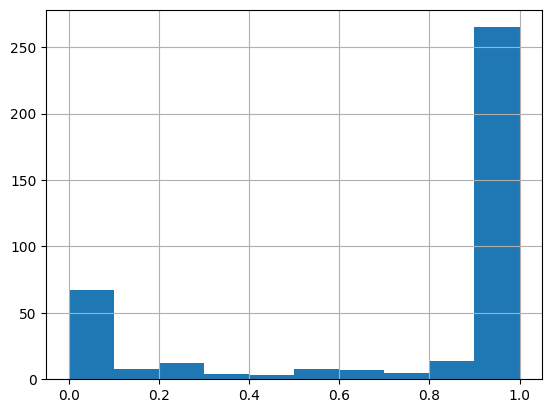

In [15]:
metadata['EUTConfidence']= preds
metadata[metadata['target']==1].EUTConfidence.hist()

In [17]:
metadata.to_csv('metadata_EUT.csv', index=False)

In [55]:
metadata= pandas.read_csv('/home/abiel/workspace/kaggle/metadata_EUT.csv').drop(columns=['Unnamed: 0'])

In [56]:
scores= 0
models= []
splits= list(StratifiedGroupKFold(n_splits=5).split(metadata, metadata['target'], groups= metadata['patient_id']))
for fold, (train_idx, valid_idx) in enumerate(splits):
    lgbm= lightgbm.LGBMClassifier(**Util.lightgbm_kwargs)

    metadata_train= metadata.iloc[train_idx].reset_index(drop=True)
    metadata_valid= metadata.iloc[valid_idx].reset_index(drop=True)

    lgbm.fit(metadata_train.drop(columns=['isic_id', 'patient_id', 'target']), metadata_train['target'])
    predictions= lgbm.predict_proba(metadata_valid.drop(columns=['isic_id', 'patient_id', 'target']))[:, 1]
    score= partial_auc(metadata_valid["target"], predictions)

    scores+= score
    models.append(lgbm)

    print(f"Fold: {fold+ 1} - Partial AUC Score: {score:.5f}")

print(f"Avg Partial AUC score: {scores/(len(models)):.3f}")
del lgbm, score, fold, metadata_valid, metadata_train

Fold: 1 - Partial AUC Score: 0.19514
Fold: 2 - Partial AUC Score: 0.19362
Fold: 3 - Partial AUC Score: 0.19543
Fold: 4 - Partial AUC Score: 0.19211
Fold: 5 - Partial AUC Score: 0.19125
Avg Partial AUC score: 0.194


In [57]:
def ensemble(test_data: pandas.DataFrame):
    predictions= numpy.zeros(test_data.shape[0])

    for model in models:
        predictions+= model.predict_proba(test_data.drop(columns=['isic_id', 'patient_id']))[:, 1]
    return predictions/len(models)

In [58]:
preds= EUT_model.inference(test_dataloader)
metadata_test['EUTConfidence']= preds

Batches: 100%|██████████| 1/1 [00:00<00:00,  3.25it/s]


In [59]:
df_sub= pandas.read_csv(Util.metadata_submission_fp)

In [60]:
df_sub["target"]= metadata_test['EUTConfidence']
df_sub['target'].mean()

8.3686323e-22

In [61]:
metadata_test['EUTConfidence']

0    2.013635e-34
1    2.510590e-21
2    4.267742e-36
Name: EUTConfidence, dtype: float32

In [37]:
df_sub["target"]= ensemble(metadata_test)
df_sub['target'].mean()

0.00011510453163629774

In [38]:
df_sub['target']

0    0.000103
1    0.000121
2    0.000121
Name: target, dtype: float64

In [ ]:
#df_sub.to_csv("submission.csv", index=False)